In [1]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [2]:
# code copied from example experiments.py
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import LiteralListener, LiteralSpeaker, ImaginativeListener, CaptionEncoder, CaptionGenerator, ColorGenerator, ColorSelector, ColorOnlyBaseline
from evaluation import score_model, delta_e_dist, Speaker, Score
from experiment import FeatureHandler, evaluate_model

In [152]:
from functools import partial

In [203]:
import matplotlib.pyplot as plt
from scipy import stats

In [185]:
%matplotlib inline

In [3]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth_10fold.csv", "../data/entries/dev_corpus_synth_10fold.pkl")

In [8]:
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)  # we'll use the EndingTokenizer in order to have common training data, but should technically be WhitespaceTokenizer
color_phi = ColorFeaturizer(color_phi_fourier, "hsv", normalized=True) # speaker uses hsv 

# speaker's target is to predict tokens following the SOS token
def speaker_target(data_entry):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target

feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi, target_fn=speaker_target, randomized_colors=False)

print("Obtaining training features")
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

# print("Initializing model")
# model = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=lr, num_epochs=epochs)
# model.init_model(color_in_dim=color_in_dim, color_dim=color_dim,
#                               vocab_size=caption_phi.caption_indexer.size, embed_dim=embed_dim,
#                              speaker_hidden_dim=hidden_dim)

Obtaining training features


In [ ]:
speaker_model = literal_speaker_experiment(train=False, model_file="../model/literal_speaker_30epochGLOVE.params")

In [140]:
class LiteralSpeakerScorer(LiteralSpeaker):
    """
    Only difference between this and above is the predict function. Above we care about generating the next tokens with beam
    search but here we want to use the model to get the log probability of the paseed feature
    """

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            all_color_outputs = []
            for i, feature in enumerate(X):
                caption, colors_before_roll = feature
                caption_tensor = torch.tensor([caption])
                
                each_color_outputs = []
                for r in range(len(colors_before_roll)):
                    # we want to get probability that each color is target
                    colors = np.roll(colors_before_roll, shift=r, axis=0)
                    # flip colors so target is last - consistent with target being last
                    colors = np.flip(colors, axis=0).copy()
                    #print(colors)
                    color_tensor = torch.tensor([colors])

                    results = self.model(color_tensor, caption_tensor)
                    each_color_outputs.append(results.squeeze()[:-1])
                
                all_color_outputs.append(each_color_outputs)
            return all_color_outputs
            

In [141]:
lss_test = LiteralSpeakerScorer(CaptionGenerator)
lss_test.init_model(color_in_dim=54, color_dim=100,
                              vocab_size=caption_phi.caption_indexer.size, embed_dim=100,
                             speaker_hidden_dim=100)
lss_test.load_model("../model/literal_speaker_30epochGLOVE.params")

In [144]:
%%time
results = lss_test.predict(train_features)

CPU times: user 2min 53s, sys: 7.97 s, total: 3min
Wall time: 2min 18s


In [78]:
results

[[tensor([[-27.8540,  -3.0829,  -2.3571,  ..., -27.8131, -28.1783, -28.1913],
          [-17.5946,  -7.0137,  -1.9252,  ..., -17.4784, -18.1368, -18.0862],
          [-24.0608, -19.6537, -16.9356,  ..., -23.9533, -24.6583, -24.6703],
          [-27.1248, -10.9085,  -6.5266,  ..., -27.0094, -27.5413, -27.5665],
          [-24.0579, -11.1345,  -6.8196,  ..., -23.9172, -24.9384, -24.8634],
          [-29.5533, -11.8077, -15.4007,  ..., -29.5044, -30.5276, -30.4941]]),
  tensor([[-27.9541,  -3.5872,  -3.4512,  ..., -27.9083, -28.2869, -28.2886],
          [-18.7501,  -7.4657,  -3.6956,  ..., -18.6515, -19.3832, -19.2965],
          [-26.2892, -19.3813, -17.6457,  ..., -26.2034, -26.9546, -26.9634],
          [-29.0063, -11.1311,  -7.5317,  ..., -28.9001, -29.4557, -29.4842],
          [-26.3040, -11.2240,  -7.7869,  ..., -26.1782, -27.2320, -27.1615],
          [-31.8857, -11.9414, -16.4160,  ..., -31.8516, -32.9098, -32.8805]]),
  tensor([[-28.6224,  -3.3702,  -2.0409,  ..., -28.5961, -29

In [80]:
train_targets[:3]

array([array([1, 2, 3, 4, 5, 6]), array([7, 6]),
       array([ 8,  9, 10,  1,  8,  2,  5,  6])], dtype=object)

In [145]:
all_scores = []
for i, predictions in enumerate(results):
    scores = [0, 0, 0]
    for j, prediction in enumerate(predictions):
        scores[j] = np.sum(prediction[np.arange(len(train_targets[i])), train_targets[i]].numpy())
    all_scores.append(scores)

In [146]:
all_scores[:3]

[[-13.632977, -12.435015, -18.771767],
 [-0.72961235, -10.730881, -7.4132004],
 [-30.176746, -30.006744, -32.74653]]

In [147]:
np.argmax(all_scores, axis=1)[:20]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0])

In [148]:
sum(np.argmax(all_scores, axis=1) == 0)/len(all_scores)

0.779572294924992

In [149]:
sum(np.argmax(all_scores, axis=1) == 1)/len(all_scores)

0.08726460261729971

In [150]:
sum(np.argmax(all_scores, axis=1) == 2)/len(all_scores)

0.13316310245770827

In [156]:
# Now let's evaluate on the dev set!
def output_to_score_lss(outputs, targets):
    all_scores = []
    for i, predictions in enumerate(outputs):
        scores = [0, 0, 0]
        for j, prediction in enumerate(predictions):
            scores[j] = np.sum(prediction[np.arange(len(targets[i])), targets[i]].numpy())
        all_scores.append(scores)
    return np.argmax(all_scores, axis=1) == 0

#     = lambda outputs, targets: np.array([delta_e_dist(outputs[i], targets[i]) for i in range(len(targets))])
# we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
# so we change the feature_handler's target function to do that:
my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
result_lss = evaluate_model(dev_data_synth, feature_handler, lss_test, output_to_score_lss, my_score_model, accuracy=False)



Got here to composite score


In [157]:
result_lss

((0.7785982802369652, 8.7767691e-316),
           gameid  roundNum  numOutcome  \
 0        synth-0         1           1   
 1        synth-0         2           1   
 2        synth-0         3           1   
 3        synth-0         4           1   
 4        synth-0         5           1   
 5        synth-0         6           1   
 6        synth-0         7           1   
 7        synth-0         8           1   
 8        synth-0         9           1   
 9        synth-0        10           1   
 10       synth-0        11           1   
 11       synth-0        12           1   
 12       synth-0        13           1   
 13       synth-0        14           1   
 14       synth-0        15           1   
 15       synth-0        16           1   
 16       synth-0        17           1   
 17       synth-0        18           1   
 18       synth-0        19           1   
 19       synth-0        20           1   
 20       synth-0        21           1   
 21       synth

(0.9357015207504799, 3.524806699889752e-235)

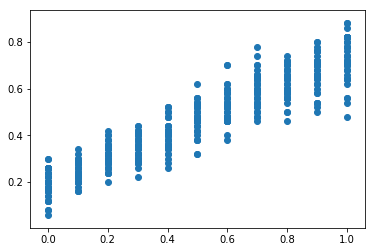

In [204]:
lss_true_scores = result_lss[1].groupby('gameid').numOutcome.mean()
lss_model_scores = result_lss[1].groupby('gameid').model_scores.mean()
plt.scatter(lss_true_scores, lss_model_scores)
stats.pearsonr(lss_true_scores, lss_model_scores)

(0.920888219330786, 7.591995245084112e-213)

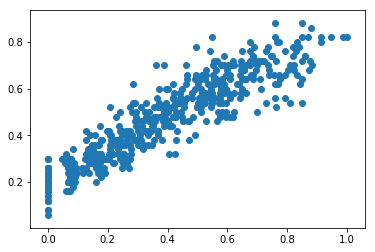

In [210]:
lss_true_scores_composite = composite_score(result_lss[1])
plt.scatter(lss_true_scores_composite, lss_model_scores)
stats.pearsonr(lss_true_scores_composite, lss_model_scores)

In [191]:
output_to_score_lss_probmass(results, train_targets)

[0.3040377,
 0.038657635,
 0.32472548,
 0.2018279,
 0.169812,
 0.13584498,
 0.14041406,
 0.2720667,
 0.18129712,
 0.049722753,
 0.10328531,
 0.31966066,
 0.2816913,
 0.29293087,
 0.110070296,
 0.23957825,
 0.26851904,
 0.18097676,
 0.14645182,
 0.24876107,
 0.2783099,
 0.32867065,
 0.10589149,
 0.28701392,
 0.31424767,
 0.24235292,
 0.053452916,
 0.29525682,
 0.026396839,
 0.19931717,
 0.044797312,
 0.04846294,
 0.3294743,
 0.3335077,
 0.024456127,
 0.29342782,
 0.027671285,
 0.2824471,
 0.07730008,
 0.14770596,
 0.36464053,
 0.027983034,
 0.29830822,
 0.044276007,
 0.026337435,
 0.121088944,
 0.2805714,
 0.3316526,
 0.15024854,
 0.20038664,
 0.07040709,
 0.0012422022,
 0.02560511,
 0.30310962,
 0.030088795,
 0.30491495,
 0.31868201,
 0.17716497,
 0.23800385,
 0.23889013,
 0.14903703,
 0.088387184,
 0.31230763,
 0.060316045,
 0.2610681,
 0.24830152,
 0.3328072,
 0.32292423,
 0.28428358,
 0.32201013,
 0.27143437,
 0.26900432,
 0.34179756,
 0.33213627,
 0.2602694,
 0.33862692,
 0.2910156

(array([2.660e+03, 1.775e+03, 2.282e+03, 3.779e+03, 4.898e+03, 2.150e+02,
        3.900e+01, 1.000e+01, 5.000e+00, 2.000e+00]),
 array([6.9995626e-04, 7.3545963e-02, 1.4639197e-01, 2.1923797e-01,
        2.9208398e-01, 3.6492997e-01, 4.3777600e-01, 5.1062196e-01,
        5.8346802e-01, 6.5631402e-01, 7.2916001e-01], dtype=float32),
 <a list of 10 Patch objects>)

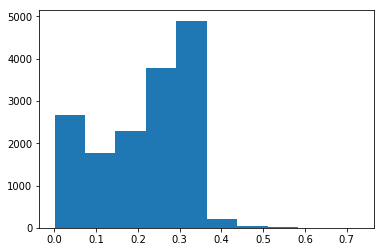

In [192]:
plt.hist(output_to_score_lss_probmass(results, train_targets))
plt.title("Direct Propotion")

Text(0.5,1,'Softmax')

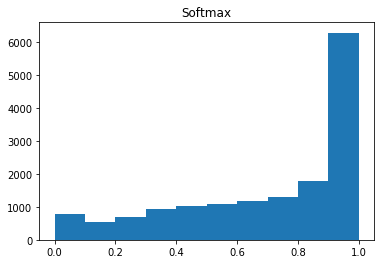

In [200]:
plt.hist(output_to_score_lss_probmass(results, train_targets))
plt.title("Softmax - sum")

Text(0.5,1,'Softmax - mean')

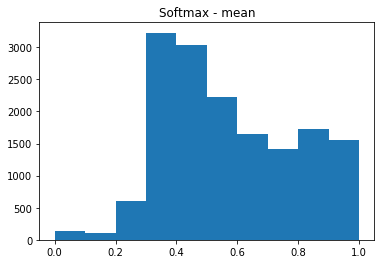

In [198]:
plt.hist(output_to_score_lss_probmass(results, train_targets))
plt.title("Softmax - mean")

In [199]:
def output_to_score_lss_probmass(outputs, targets):
    all_scores = []
    for i, predictions in enumerate(outputs):
        scores = np.array([0, 0, 0], dtype=np.float64)
        for j, prediction in enumerate(predictions):
            scores[j] = np.sum(prediction[np.arange(len(targets[i])), targets[i]].numpy())
            #scores[j] = np.mean(prediction[np.arange(len(targets[i])), targets[i]].numpy())
        # softmax scores
        if np.sum(np.exp(scores)) == 0:
            print(scores)
        else:
            scores = np.exp(scores) / np.sum(np.exp(scores))
        #scores = np.array(scores)/sum(scores)
        # take the portion of the distribution asssigned to target (@ index 0)
            all_scores.append(scores[0])
    return all_scores

# my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
# result_lss = evaluate_model(dev_data_synth, feature_handler, lss_test, output_to_score_lss, my_score_model, accuracy=False)


In [201]:
result_lss_softmax = evaluate_model(dev_data_synth, feature_handler, lss_test, output_to_score_lss_probmass, my_score_model, accuracy=False)


Got here to composite score


(0.9510342653057082, 9.078467860995346e-265)

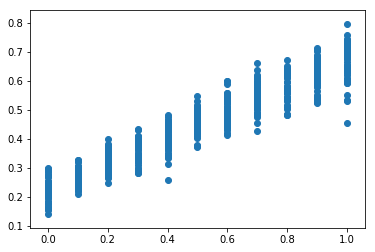

In [205]:
lss_softmax_true_scores = result_lss_softmax[1].groupby('gameid').numOutcome.mean()
lss_softmax_model_scores = result_lss_softmax[1].groupby('gameid').model_scores.mean()
plt.scatter(lss_softmax_true_scores, lss_softmax_model_scores)
stats.pearsonr(lss_softmax_true_scores, lss_softmax_model_scores)

So this does pretty well, but not necessarily as well as the other methods.

In [206]:
def composite_score(eval_df, speaker="gameid"):
    """
    This is the scoring function that Julia came up with
    """
    mean_scores = eval_df.groupby(speaker).numOutcome.mean()
    mean_numCleanWords = eval_df.groupby(speaker).numCleanWords.mean()
    mean_clkTime = eval_df.groupby(speaker).clkTime.mean()
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores
    return true_scores

(0.933926390187631, 3.096658675805076e-232)

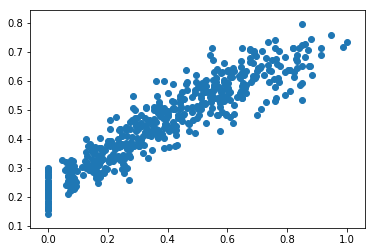

In [208]:
lss_softmax_true_scores_composite = composite_score(result_lss_softmax[1])
plt.scatter(lss_softmax_true_scores_composite, lss_softmax_model_scores)
stats.pearsonr(lss_softmax_true_scores_composite, lss_softmax_model_scores)

1) Game: 1124-1 Round: 2
purple


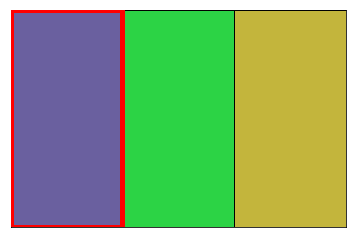

In [92]:
train_data.display_game(1)

In [127]:
caption_phi.caption_indexer.idx2word[13]

'green'

In [98]:
train_features[1]

[array([0, 7, 6]),
 array([[ 1.        , -0.38268343, -0.70710677,  0.309017  , -0.9969173 ,
          0.4539905 , -0.809017  , -0.23344536,  0.98768836, -0.35836795,
          0.99965733, -0.40673664,  0.777146  ,  0.28401536, -0.9945219 ,
          0.83867055, -0.8241262 , -0.20791169, -0.7431448 , -0.33380687,
          0.9986295 , -0.8660254 ,  0.7933533 ,  0.25881904,  0.20791169,
          0.8241262 , -0.83867055,  0.        , -0.9238795 ,  0.70710677,
         -0.95105654,  0.0784591 ,  0.8910065 , -0.58778524,  0.9723699 ,
         -0.15643446,  0.9335804 , -0.02617695, -0.9135454 ,  0.6293204 ,
         -0.95881975,  0.10452846, -0.54463905, -0.56640625,  0.9781476 ,
         -0.6691306 ,  0.9426415 , -0.05233596,  0.5       ,  0.6087614 ,
         -0.9659258 ,  0.9781476 , -0.56640625, -0.54463905],
        [ 1.        , -0.86074203,  0.48175368, -0.8000254 ,  0.38320792,
          0.14033912,  0.28008136,  0.24758989, -0.7063034 , -0.6293204 ,
          0.14608303,  0.377840

In [142]:
result_test = lss_test.predict([train_features[1]])

In [100]:
result_test

[[tensor([[-25.5483,  -4.0402, -14.8709,  ..., -25.4969, -26.0147, -26.0138],
          [-29.4434, -12.3670, -15.3185,  ..., -29.3245, -30.1188, -30.0315]]),
  tensor([[-19.6682,  -5.7760, -15.8227,  ..., -19.5386, -19.9056, -19.8564],
          [-18.1489, -31.7623, -72.8551,  ..., -18.0001, -19.1636, -19.0562]]),
  tensor([[-29.5389,  -4.2190,  -4.0733,  ..., -29.4880, -29.9500, -29.9098],
          [-29.7806, -24.3776, -39.4509,  ..., -29.6602, -30.4670, -30.4489]])]]

In [143]:
[result_test[0][i][0][7] for i in range(3)]

[tensor(-0.6007), tensor(-10.5241), tensor(-7.3729)]

In [26]:
np.array([1, 2, 3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

In [28]:
np.expand_dims(np.array([1, 2, 3]), axis=0)

array([[1, 2, 3]])

In [124]:
model_s = LiteralSpeaker(CaptionGenerator)
model_s.init_model(color_in_dim=54, color_dim=100,
                              vocab_size=caption_phi.caption_indexer.size, embed_dim=100,
                             speaker_hidden_dim=100)
model_s.load_model("../model/literal_speaker_30epochGLOVE.params")

In [125]:
model_s.predict([train_features[1]], sample=1, beam_width=1)

[array([[ 0,  7,  6],
        [ 0, 33,  6],
        [ 0, 13,  6]])]